# Imports

In [ ]:
#Creating a clean Slate
from IPython import get_ipython
get_ipython().magic('reset -sf')
#Directing to the correct location and getting the file
import os
#os.chdir('C:/Users/ritux/OneDrive - Danmarks Tekniske Universitet/Skrivebord/3 -Computational Tools for Data Science/')
import requests
import pandas as pd
from bs4 import BeautifulSoup
from urllib.parse import urljoin

C:\Users\ritux\AppData\Local\Temp\ipykernel_13132\2114608133.py:3: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -sf')


# Support Functions

In [ ]:
headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:132.0) Gecko/20100101 Firefox/132.0',
            'Accept-Language': 'en-US,en;q=0.9',
            'Referer': 'https://www.google.com/'  # Sometimes needed to bypass blocks
        }

## Scraping

In [ ]:
def url_scrapping(base_url,limit,headers=headers):

    urls = [] # List of urls

    to_visit = [base_url] # Queue
    while to_visit and len(urls) < limit:
        
        # Getting an URL form the queue
        current_url = to_visit.pop(0)
        # Issuing the request for access to the webpage
        response = requests.get(current_url, headers=headers)
        # Ensuring we are successful in the request
        if response.status_code != 200:
            print(f"Request failed with status code {response.status_code} at url: {current_url}")
        
        # Obtaining the information in the webpage
        Soup = BeautifulSoup(response.text, 'html.parser')
        # Iterating through the linked pages from the page we are visiting
        for a in Soup.find_all('a', href=True): 
            url = urljoin(base_url, a['href'])
            # Ensuring it stays within the chosen page
            if url.startswith(base_url) and url: 
                # Keeping only new urls 
                if url not in urls:
                    urls.append(url)
                    # Adding to queue only unscheduled urls
                    if url not in to_visit: 
                        to_visit.append(url)
    return urls


## Filtering

In [ ]:
def filter_urls(urls, limit,condition,headers=headers):
    filtered_urls = []
    for url in urls:
        try:
            # Fetch the page
            response = requests.get(url, headers=headers)
            if response.status_code != 200:
                print(f"Request failed with status code {response.status_code} at url: {url}")
            
            soup = BeautifulSoup(response.text, 'html.parser')

            # Check if the page contains the ingredient selector
            if soup.select(condition) and url not in filtered_urls:
                filtered_urls.append(url)
                
                # Stop if we've reached the limit
                if len(filtered_urls) >= limit:
                    break
        except requests.RequestException as e:
            print(f"Error fetching {url}: {e}")
            continue  # Skip to the next URL in case of an error

    return filtered_urls


In [ ]:
# Function to filter URLs
def bcc_filter_urls(urls, limit,headers=headers):
    filtered_urls = []
    for url in urls:
        segments = url.split('/')
        if url.startswith('https://www.bbc.co.uk/') and url.startswith('https://www.bbc.co.uk/food/recipes') and len(segments) in [6,7]:
            try:
                response = requests.get(url,headers=headers)
                if response.status_code != 200:
                    print(f"Request failed with status code {response.status_code} at url: {url}")
            
                soup = BeautifulSoup(response.text, 'html.parser')
                # Check if the page contains the ingredients
                if soup.select_one("div.recipe-ingredients-wrapper ul.recipe-ingredients__list li.recipe-ingredients__list-item a.recipe-ingredients__link")  and url not in filtered_urls:
                    filtered_urls.append(url)
                    if len(filtered_urls) >= limit:
                        break
            except requests.RequestException as e:
                print(f"Error fetching {url}: {e}")
                continue  # Skip to the next URL in case of an error

    return filtered_urls

## Ingredients

In [ ]:
# Function to extract ingredients from BBC website
def bbc_get_ingredients(urls):
    ingredients = []
    for url in urls:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.select_one("h1.content-title__text").text.strip()
        recipe_ingredients = []
        # Use soup.select with the CSS selector for ingredients
        for item in soup.select("div.recipe-ingredients-wrapper ul.recipe-ingredients__list li.recipe-ingredients__list-item a.recipe-ingredients__link"):
            name = item.text.strip()
            # Combine to form a full ingredient line
            recipe_ingredients.append({'title': title,'description': name})
        ingredients.append(recipe_ingredients)
    return ingredients

In [ ]:
def all_get_ingredients(urls):
    ingredients = []
    for url in urls:
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.select_one("title").text.strip()
        recipe_ingredients = []
        # Use soup.select with the CSS selector for ingredients
        for item in soup.select("ul.mm-recipes-structured-ingredients__list > li.mm-recipes-structured-ingredients__list-item"):
            name = item.select_one("span[data-ingredient-name]").get_text(strip=True)
            # Combine to form a full ingredient line
            recipe_ingredients.append({'title': title,'description': name})
        ingredients.append(recipe_ingredients)
    return ingredients

In [ ]:
def two_get_ingredients(urls):
    ingredients = []
    for url in urls:
        # Fetch the page content
        response = requests.get(url, headers=headers)
        soup = BeautifulSoup(response.text, 'html.parser')
        title = soup.select_one("title").text.strip()
        recipe_ingredients = []
        # Use soup.select with the CSS selector for ingredients
        for item in soup.select(".wprm-recipe-ingredient"):
            # Get name if they exist
            name = item.select_one(".wprm-recipe-ingredient-name")
            if name:# Add to ingredients list
                name = name.get_text(strip=True)
                # Combine to form a full ingredient line
                recipe_ingredients.append({'title': title,'description': name})
                
        ingredients.append(recipe_ingredients)
    return ingredients

# Body

In [ ]:
bbc_url = 'https://www.bbc.co.uk/food/recipes'
all_url = "https://www.allrecipes.com"
two_url = 'https://www.twopeasandtheirpod.com/'

bbc_scraped_urls = url_scrapping(bbc_url,1000)
all_scraped_urls = url_scrapping(all_url,1000)
two_scraped_urls = url_scrapping(two_url,1000)


Request failed with status code 403 at url: https://www.twopeasandtheirpod.com/wp-login.php?redirect_to=https%3A%2F%2Fwww.twopeasandtheirpod.com%2Fsaved-recipes%2F


In [ ]:
all_con = "li.mm-recipes-structured-ingredients__list-item"
two_con = ".wprm-recipe-ingredient"

bbc_url_filterd = bcc_filter_urls(bbc_scraped_urls, 1000,headers=headers)
all_url_filterd = filter_urls(all_scraped_urls, 1000,all_con,headers=headers)
two_url_filterd = filter_urls(two_scraped_urls, 1000,two_con,headers=headers)


Request failed with status code 404 at url: https://www.allrecipes.com/realms/alrcom/broker/facebook/login?client_id=alrcom&tab_id=swrShh18Yq4&session_code=HWYwSygV2-iLyaAFvoDFm6hNI-_Ohbgz80ojxcQM_QQ
Request failed with status code 404 at url: https://www.allrecipes.com/realms/alrcom/broker/google/login?client_id=alrcom&tab_id=swrShh18Yq4&session_code=HWYwSygV2-iLyaAFvoDFm6hNI-_Ohbgz80ojxcQM_QQ
Request failed with status code 404 at url: https://www.allrecipes.com/realms/alrcom/login-actions/registration?client_id=alrcom&tab_id=swrShh18Yq4
Request failed with status code 404 at url: https://www.allrecipes.com/realms/alrcom/broker/facebook/login?client_id=alrcom&tab_id=qE8HMqXMlvI&session_code=a9e2BsNbGyZyiir1CYlNxRFpNfM8mYg8cB4EvlmtLAc
Request failed with status code 404 at url: https://www.allrecipes.com/realms/alrcom/broker/google/login?client_id=alrcom&tab_id=qE8HMqXMlvI&session_code=a9e2BsNbGyZyiir1CYlNxRFpNfM8mYg8cB4EvlmtLAc
Request failed with status code 404 at url: https://www.

C:\Users\ritux\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


Request failed with status code 403 at url: https://www.twopeasandtheirpod.com/wp-login.php/


In [ ]:
two_ingredients = two_get_ingredients(two_url_filterd)
all_ingredients = all_get_ingredients(all_url_filterd)
bcc_ingredients = bbc_get_ingredients(bbc_url_filterd)

## Concatenate the three websites

In [20]:
print("For bbc:")
print("Number of URLs found :" , len(bbc_scraped_urls))
print("Number of URLs filtered:" , len(bbc_url_filterd))
print("Number of URLs with recipes:" , len(bcc_ingredients))
n_bcc =len(bcc_ingredients)
print("\n")
print("For all:")
print("Number of URLs found :" , len(all_scraped_urls))
print("Number of URLs filtered:" , len(all_url_filterd))
print("Number of URLs with recipes:" , len(all_ingredients))
n_all =len(all_ingredients)
print("\n")
print("For two:")
print("Number of URLs found :" , len(two_scraped_urls))
print("Number of URLs filtered:" , len(two_url_filterd))
print("Number of URLs with recipes:" , len(two_ingredients))
n_two =len(two_ingredients)



For bbc:
Number of URLs found : 1013
Number of URLs filtered: 552
Number of URLs with recipes: 552


For all:
Number of URLs found : 1311
Number of URLs filtered: 581
Number of URLs with recipes: 581


For two:
Number of URLs found : 1085
Number of URLs filtered: 417
Number of URLs with recipes: 417


In [21]:
count  = 0
all_ingredients_df = pd.DataFrame(columns=['id','source','link', 'title'])
for n in range(n_bcc):
    count += 1
    ingredients_df= pd.DataFrame(bcc_ingredients[n])
    ingredients_df['id'] = count
    ingredients_df['source'] = 'bbc'
    ingredients_df['link'] = bbc_url_filterd[n]
    ingredients_df['title'] = ' '    
    all_ingredients_df = pd.concat([all_ingredients_df, ingredients_df], ignore_index=True)

for n in range(n_all):
    count += 1
    ingredients_df= pd.DataFrame(all_ingredients[n])
    ingredients_df['id'] = count
    ingredients_df['source'] = 'all'
    ingredients_df['link'] = all_url_filterd[n]
    ingredients_df['title'] = ' '
    all_ingredients_df = pd.concat([all_ingredients_df, ingredients_df], ignore_index=True)

for n in range(n_two):
    count += 1
    ingredients_df= pd.DataFrame(two_ingredients[n])
    ingredients_df['id'] = count
    ingredients_df['source'] = 'two'
    ingredients_df['link'] = two_url_filterd[n]
    ingredients_df['title'] = ' '
    all_ingredients_df = pd.concat([all_ingredients_df, ingredients_df], ignore_index=True)


In [22]:
all_ingredients_df

,id,source,link,title,0
0,1,bbc,https://www.bbc.co.uk/food/recipes/healthy_chi...,,beef mince
1,1,bbc,https://www.bbc.co.uk/food/recipes/healthy_chi...,,red onion
2,1,bbc,https://www.bbc.co.uk/food/recipes/healthy_chi...,,garlic
3,1,bbc,https://www.bbc.co.uk/food/recipes/healthy_chi...,,courgette
4,1,bbc,https://www.bbc.co.uk/food/recipes/healthy_chi...,,aubergine
...,...,...,...,...,...
18668,1550,two,https://www.twopeasandtheirpod.com/pumpkin-bun...,,100% pure pumpkin
18669,1550,two,https://www.twopeasandtheirpod.com/pumpkin-bun...,,"cream cheese,"
18670,1550,two,https://www.twopeasandtheirpod.com/pumpkin-bun...,,confectioner's sugar
18671,1550,two,https://www.twopeasandtheirpod.com/pumpkin-bun...,,vanilla extract


In [23]:
all_ingredients_df.to_csv('recipes_data.csv', index=False)

# Saving

In [25]:
scraped_urls = bbc_scraped_urls + all_scraped_urls + two_scraped_urls
scraped_urls_df = pd.DataFrame({'scraped_urls': scraped_urls})
scraped_urls_df.to_csv('scraped_urls.csv', index=False)

In [26]:
url_filterd = bbc_url_filterd + all_url_filterd + two_url_filterd
url_filterd_df = pd.DataFrame({'url_filterd': url_filterd})
url_filterd_df.to_csv('url_filterd.csv', index=False)

# Data

In [1]:
from nltk.corpus import stopwords
from nltk import FreqDist, bigrams
from nltk.tokenize import word_tokenize
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
import pandas as pd

In [51]:
df = pd.read_csv('data/recipes_data.csv')

In [52]:
df.head()

,id,source,link,title,description
0,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,olive oil
1,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,chicken breast
2,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,butter
3,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,garlic
4,1,bbc,https://www.bbc.co.uk/food/recipes/chicken_and...,Chicken and tomato pasta,rosemary


In [53]:
words = [word for document in df['description'] for word in str(document).split()]

# Word Count
total_words = len(words)
print(f'Total words: {total_words}')

# Unique Word Count
unique_words = len(set(words))
print(f'Unique words: {unique_words}')

# Most Common Words (excluding stopwords)
stop_words = set(stopwords.words('english'))
non_stopwords = [word for word in words if word not in stop_words]
most_common_words = Counter(non_stopwords).most_common(15)
print(f'Most common words: {most_common_words}')

# Most Common Stop Words
stopwords_in_text = [word for word in words if word in stop_words]
most_common_stopwords = Counter(stopwords_in_text).most_common(15)
print(f'Most common stop words: {most_common_stopwords}')
#count of stop words in df
print(f"Total amount of stop words: {len(stopwords_in_text)}")


Total words: 28433
Unique words: 1128
Most common words: [('pepper', 1244), ('oil', 936), ('salt', 927), ('onion', 776), ('garlic', 772), ('black', 753), ('butter', 676), ('chicken', 516), ('sugar', 515), ('olive', 514), ('egg', 446), ('flour', 426), ('cheese', 405), ('powder', 378), ('tomato', 367)]
Most common stop words: []
Total amount of stop words: 0


# Data Cleaning

There are some empty ingredients and NaN values in the dataset. We will remove those.


In [54]:
# Clean the DataFrame
df['description'] = df['description'].fillna('').astype(str)

In [55]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from ingredient_parser import parse_ingredient

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# List of irrelevant words to remove
irrelevant_words = ['prepared', 'fresh', 'ready', 'to', 'eat', 'other', 'specialities', 'without', 'fillings', 'based', 'alternatives']

flatten = lambda List:  list(set(sum(List ,[])))
no_punct = lambda word: word.translate(str.maketrans('', '',string.punctuation))

def split_by_stopwords(phrase):
    stop_words = set(stopwords.words('english'))
        
    # Find stopwords in the phrase
    stopwords_in_text = [word for word in phrase.split() if word in stop_words]

    # Initialize a list to hold the split phrases
    split_phrases = [phrase]

    # Split the phrase based on the stopwords
    for stopword in stopwords_in_text:
        temp = []
        for part in split_phrases:
            temp.extend(part.split(f" {stopword} "))
        split_phrases = temp

    # Filter empty strings and strip spaces
    return [part.strip() for part in split_phrases if part.strip()]

def get_ingredients(words):
    List = []
    for word in words:
        ingredient = parse_ingredient(word, discard_isolated_stop_words=True).name
        if ingredient:
            List.append(ingredient.text)
    return List

# Function to clean ingredients in the DataFrame
def clean_ingredients_in_df(df):
    cleaned_ingredients = []
    for desc in df['description']:
        # Remove punctuation
        desc_no_punct = no_punct(desc)
        # Split by stopwords
        split_phrases = split_by_stopwords(desc_no_punct)
        # Get ingredients
        ingredients = get_ingredients(split_phrases)
        # Lemmatize and filter out verbs and irrelevant words
        lemmatized_ingredients = []
        for ingredient in ingredients:
            words = word_tokenize(ingredient.lower())
            pos_tags = nltk.pos_tag(words)
            filtered_words = [lemmatizer.lemmatize(word) for word, pos in pos_tags if pos[0] != 'V' and word not in stop_words and word not in irrelevant_words]
            lemmatized_ingredients.append(' '.join(filtered_words))
        # Join the cleaned ingredients into a single string
        cleaned_ingredients.append(' '.join(lemmatized_ingredients))
    return cleaned_ingredients

In [56]:
# Apply the function to the DataFrame
df['cleaned_ingredients'] = clean_ingredients_in_df(df)

# Display the final DataFrame
df[['id', 'title', 'description','cleaned_ingredients']]

,id,title,description,cleaned_ingredients
0,1,Chicken and tomato pasta,olive oil,olive oil
1,1,Chicken and tomato pasta,chicken breast,chicken breast
2,1,Chicken and tomato pasta,butter,butter
3,1,Chicken and tomato pasta,garlic,garlic
4,1,Chicken and tomato pasta,rosemary,rosemary
...,...,...,...,...
16721,1513,Creamy Cajun Potato Soup Recipe,andouille sausage,andouille sausage
16722,1513,Creamy Cajun Potato Soup Recipe,vegetable broth,vegetable broth
16723,1513,Creamy Cajun Potato Soup Recipe,heavy cream,heavy cream
16724,1513,Creamy Cajun Potato Soup Recipe,cajun,cajun


In [57]:
# Identify the ingredients that changed
original_ingredients = []
cleaned_ingredients = []
for original, cleaned in zip(df['description'], df['cleaned_ingredients']):
    if original != cleaned:
        original_ingredients.append(original)
        cleaned_ingredients.append(cleaned)

# Display the original and cleaned ingredients in a DataFrame
changed_ingredients_df = pd.DataFrame({'original': original_ingredients, 'cleaned': cleaned_ingredients})
changed_ingredients_df

,original,cleaned
0,chopped tomato,tomato
1,chopped tomato,tomato
2,brussels sprout,brussels
3,chopped tomato,tomato
4,chopped tomato,tomato
...,...,...
292,ramen noodle,ramen
293,italian seasoning taste,italian taste
294,parsley flake dill,parsley dill
295,tomato basil garlic oregano,tomato garlic oregano


As it is visible the cleane up work but it is not perfect. This model could be improved further.

In [58]:
# Median number of ingredients per id
median_ingredients = df.groupby('id').size().median()
print(f"Average: {median_ingredients}")

# Minimum number of ingredients per id
min_ingredients = df.groupby('id').size().min()
print(f"Minimum ingredients per id: {min_ingredients}")

# Maximum number of ingredients per id
max_ingredients = df.groupby('id').size().max()
print(f"Maximum ingredients per id: {max_ingredients}")

# Standard deviation of the number of ingredients per id
std_ingredients = df.groupby('id').size().std()
print(f"Standard deviation: {std_ingredients}")

Average: 10.0
Minimum ingredients per id: 1
Maximum ingredients per id: 44
Standard deviation: 5.4838897528784205


In [59]:
words = [word for document in df['cleaned_ingredients'] for word in str(document).split()]

# Word Count
total_words = len(words)
print(f'Total words: {total_words}')

# Unique Word Count
unique_words = len(set(words))
print(f'Unique words: {unique_words}')



# Most Common Words (excluding stopwords)
stop_words = set(stopwords.words('english'))
non_stopwords = [word for word in words if word not in stop_words]
most_common_words = Counter(non_stopwords).most_common(15)
print(f'Most common words: {most_common_words}')

# Most Common Stop Words
stopwords_in_text = [word for word in words if word in stop_words]
most_common_stopwords = Counter(stopwords_in_text).most_common(15)
print(f'Most common stop words: {most_common_stopwords}')
#count of stop words in df
print(f"Total amount of stop words: {len(stopwords_in_text)}")


Total words: 28058
Unique words: 1111
Most common words: [('pepper', 1198), ('oil', 936), ('salt', 927), ('onion', 776), ('garlic', 772), ('black', 753), ('butter', 676), ('sugar', 515), ('olive', 511), ('chicken', 497), ('egg', 446), ('flour', 426), ('cheese', 405), ('powder', 378), ('tomato', 367)]
Most common stop words: []
Total amount of stop words: 0


In [63]:
# delete lines with no ingredients
df = df[df['cleaned_ingredients'] != '']

In [64]:
# save the cleaned data
#drop the description column
cleaned_df = df.drop(columns=['description'])
#rename cleaned_ingredients to description
cleaned_df = cleaned_df.rename(columns={'cleaned_ingredients': 'description'})
cleaned_df.to_csv('data/recipes_data.csv', index=False)

# TF-IDF

In [71]:
recipes = pd.read_csv('data/recipes_data.csv')

A TF-IDF was used to determine the most important ingredient in a recipe.

In [99]:
from math import log

# Preprocess the ingredients to join multi-word ingredients with an underscore
recipes['description'] = recipes['description'].apply(lambda x: x.replace(' ', '_'))

# Calculate IDF
number_of_recipes = recipes['id'].nunique()  # Total number of unique recipes
ingredient_recipes = recipes.groupby('description')['id'].nunique()  # Recipes containing each ingredient
idf = ingredient_recipes.apply(lambda x: log(number_of_recipes / x)).rename('idf')  # IDF for each ingredient

# Calculate TF
tf = recipes.groupby(['id', 'description']).size().rename('tf')  # Term Frequency for each ingredient in each recipe

# Combine TF and IDF to calculate TF-IDF
# Merge TF and IDF into one DataFrame
tf_idf = tf.reset_index().merge(idf.reset_index(), on='description')

# Calculate TF-IDF
tf_idf['tf_idf'] = tf_idf['tf'] * tf_idf['idf']

# Sort by TF-IDF and drop duplicates to get the highest TF-IDF for each recipe
best = tf_idf.sort_values('tf_idf', ascending=False).drop_duplicates('id')

# Merge with the original recipes DataFrame to get the recipe name
best = best.merge(recipes[['id', 'title']].drop_duplicates(), on='id')

# Replace underscores with spaces in the description
best['description'] = best['description'].apply(lambda x: x.replace('_', ' '))

# Display the final DataFrame
best[['id', 'title', 'description', 'tf_idf']]

,id,title,description,tf_idf
0,247,Nasu dengaku (miso aubergine),miso,34.274471
1,521,Vegan porridge,almond milk,26.514810
2,77,Fabulous fruity jewelled tarts,berry,24.892950
3,323,Radish tart,radish,20.077058
4,157,Jalebi with pistachio ice cream,pistachio,18.731170
...,...,...,...,...
1508,633,Fluffy Microwave Scrambled Eggs Recipe,milk,2.085408
1509,730,Scrambled Eggs in a Mug Recipe,milk,2.085408
1510,1208,Fluffy Microwave Scrambled Eggs Recipe,milk,2.085408
1511,1305,Scrambled Eggs in a Mug Recipe,milk,2.085408


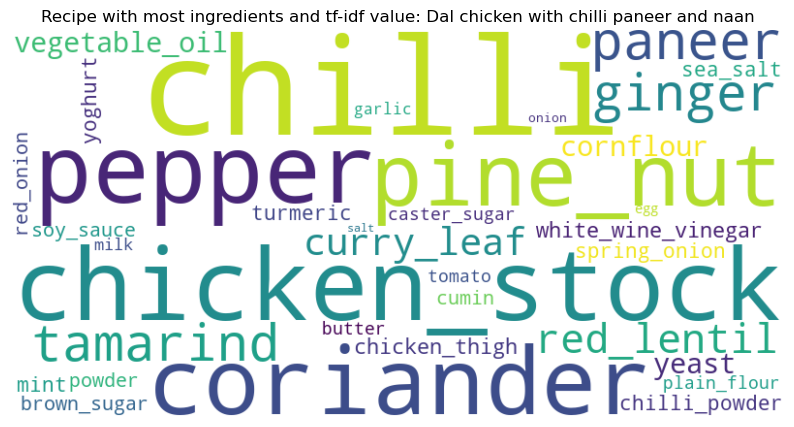

In [106]:
# print a word cloud of the recipe with more ingredients and the size of ingredients acoording to tf-idf value

from wordcloud import WordCloud
import matplotlib
import matplotlib.pyplot as plt

# Get the recipe with more count ingredients
recipe_with_most_ingredients = recipes.groupby('id').size().idxmax()
most_ingredients = recipes[recipes['id'] == recipe_with_most_ingredients]['description']

# Create a dictionary with the TF-IDF for this recipe
tf_idf_dict = tf_idf[tf_idf['id'] == recipe_with_most_ingredients].set_index('description')['tf_idf'].to_dict()

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate_from_frequencies(tf_idf_dict)

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title(f'Recipe with most ingredients and tf-idf value: {recipes[recipes["id"] == recipe_with_most_ingredients]["title"].values[0]}')
plt.axis('off')
plt.show()

